# Inspiration

Breaking the 4 minute mile barrier was a very arduous road. What is great about the record was the fact that right after this event, many other people were able to decrease this time. This means people operate under the premise of belief. Once someone has broken the "impossible" it is much easier for others to follow. This is true for any sport and powerlifting is no exception.

In the sport of powerlifting, people compete in different weight classes in three events: Squat, Benchpress, and Deadlift. These events are totaled and those who score the highest amount wins their weight class.

After segmenting the dataset to only include the 1st place winners, and by weight class, we will introduce a time series analysis. Ultimately, is there an over-all increasing trend in strength? If so, is it seasonal or are there outliers / anomalies to this data?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import itertools

In [2]:
op_df = pd.read_csv('openpowerlifting.csv')
op_df.tail()

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,Squat4Kg,BestSquatKg,Bench4Kg,BestBenchKg,Deadlift4Kg,BestDeadliftKg,TotalKg,Place,Wilks
386409,8481,William Barabas,M,Multi-ply,NaN,Elite,113.58,125,NaN,NaN,NaN,NaN,NaN,347.5,347.5,2,202.60
386410,8481,Justin Zottl,M,Multi-ply,NaN,Elite,119.02,125,NaN,NaN,NaN,NaN,NaN,322.5,322.5,3,185.77
386411,8481,Jake Anderson,M,Multi-ply,NaN,Elite,120.29,125,NaN,NaN,NaN,NaN,NaN,367.5,367.5,1,211.17
386412,8481,Jeff Bumanglag,M,Multi-ply,NaN,Elite,126.73,140,NaN,NaN,NaN,NaN,NaN,320.0,320.0,3,181.85
386413,8481,Shane Hammock,M,Multi-ply,NaN,Elite,129.46,140,NaN,NaN,NaN,NaN,NaN,362.5,362.5,2,205.18


## Data Wrangling

In [3]:
#Dropping columns with NaN values
op_df = op_df.drop(['Name', 'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg'], axis=1)
op_df.head()

,MeetID,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks
0,0,F,Wraps,47.0,Mst 45-49,59.60,60,47.63,20.41,70.31,138.35,1,155.05
1,0,F,Single-ply,42.0,Mst 40-44,58.51,60,142.88,95.25,163.29,401.42,1,456.38
2,0,F,Single-ply,42.0,Open Senior,58.51,60,142.88,95.25,163.29,401.42,1,456.38
3,0,F,Raw,42.0,Open Senior,58.51,60,NaN,95.25,NaN,95.25,1,108.29
4,0,F,Raw,18.0,Teen 18-19,63.68,67.5,NaN,31.75,90.72,122.47,1,130.47


In [4]:
print(op_df.isnull().sum())

MeetID                 0
Sex                    0
Equipment              0
Age               239267
Division           15843
BodyweightKg        2402
WeightClassKg       3812
BestSquatKg        88343
BestBenchKg        30050
BestDeadliftKg     68567
TotalKg            23177
Place               1092
Wilks              24220
dtype: int64


In [5]:
op_df = op_df.dropna()

In [6]:
#Final Check for NaN values
op_df.isnull().sum()

MeetID            0
Sex               0
Equipment         0
Age               0
Division          0
BodyweightKg      0
WeightClassKg     0
BestSquatKg       0
BestBenchKg       0
BestDeadliftKg    0
TotalKg           0
Place             0
Wilks             0
dtype: int64

In [7]:
#Creating categories for age bracket

def age(x):
    if(x < 10.0):
        return "05-10"
    if(x >= 10.0 and x < 20.0):
        return "10-20"
    if(x >= 20.0 and x < 30.0):
        return "20-30"
    if(x >= 30.0 and x < 40.0):
        return "30-40"
    if(x >= 40.0 and x < 50.0):
        return "40-50"
    if(x >= 50.0 and x < 60.0):
        return "50-60"
    if(x >= 60.0 and x < 70.0):
        return "60-70"
    if(x >= 70.0 and x < 80.0):
        return "70-80"
    if(x >= 80.0 and x < 90.0):
        return "80-90"
    else:
        return "90-100"
    


op_df['Agecategory'] = pd.DataFrame(op_df['Age'].apply(lambda x : age(x)))

In [8]:
#Creating dataframe for people who earned first place
firstPlace_df = op_df.loc[op_df['Place'] == '1']

In [9]:
#Loading meets to find date of meet
meets_df = pd.read_csv('meets.csv')
meets_df.head()

,MeetID,MeetPath,Federation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,0,365strong/1601,365Strong,2016-10-29,USA,NC,Charlotte,2016 Junior & Senior National Powerlifting Cha...
1,1,365strong/1602,365Strong,2016-11-19,USA,MO,Ozark,Thanksgiving Powerlifting Classic
2,2,365strong/1603,365Strong,2016-07-09,USA,NC,Charlotte,Charlotte Europa Games
3,3,365strong/1604,365Strong,2016-06-11,USA,SC,Rock Hill,Carolina Cup Push Pull Challenge
4,4,365strong/1605,365Strong,2016-04-10,USA,SC,Rock Hill,Eastern USA Challenge


In [10]:
#Dropping Columns that won't be needed
meets_df = meets_df.drop(['MeetPath', 'MeetCountry', 'MeetName', 'MeetState', 'MeetTown'], axis=1)
meets_df.head()

,MeetID,Federation,Date
0,0,365Strong,2016-10-29
1,1,365Strong,2016-11-19
2,2,365Strong,2016-07-09
3,3,365Strong,2016-06-11
4,4,365Strong,2016-04-10


In [11]:
#Merging meets_df with first place winners based on MeetID
merged_df = meets_df.merge(firstPlace_df, how = 'inner', on = ['MeetID'])

In [12]:
#Turning date to datetime and setting it as the index
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.set_index('Date', inplace=True)

merged_df.index

DatetimeIndex(['2016-10-29', '2016-10-29', '2016-10-29', '2016-10-29',
               '2016-10-29', '2016-10-29', '2016-10-29', '2016-10-29',
               '2016-10-29', '2016-10-29',
               ...
               '2017-07-01', '2017-07-01', '2017-07-01', '2017-07-01',
               '2017-07-01', '2017-07-01', '2017-07-01', '2017-07-01',
               '2017-07-01', '2017-07-01'],
              dtype='datetime64[ns]', name='Date', length=52219, freq=None)

In [13]:
merged_df.head()

,MeetID,Federation,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks,Agecategory
Date,,,,,,,,,,,,,,,
2016-10-29,0,365Strong,F,Wraps,47.0,Mst 45-49,59.60,60,47.63,20.41,70.31,138.35,1,155.05,40-50
2016-10-29,0,365Strong,F,Single-ply,42.0,Mst 40-44,58.51,60,142.88,95.25,163.29,401.42,1,456.38,40-50
2016-10-29,0,365Strong,F,Single-ply,42.0,Open Senior,58.51,60,142.88,95.25,163.29,401.42,1,456.38,40-50
2016-10-29,0,365Strong,F,Wraps,28.0,Open Senior,62.41,67.5,170.10,77.11,145.15,392.36,1,424.40,20-30
2016-10-29,0,365Strong,F,Raw,60.0,Mst 60-64,67.31,67.5,124.74,95.25,163.29,383.28,1,391.98,60-70


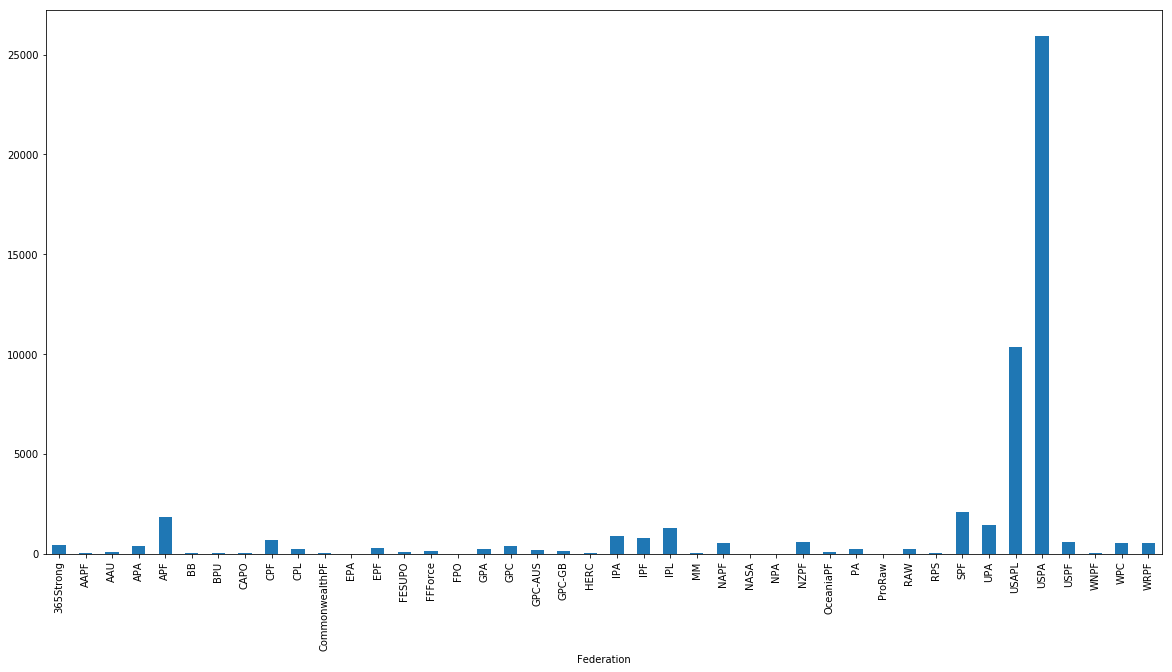

In [14]:
#Choosing strictly United States federation with highest number of participants
merged_df.groupby('Federation').size().plot(kind='bar',figsize = (20,10))

In [15]:
df = merged_df.loc[(merged_df['Federation'] == 'USPA')]

In [16]:
#df

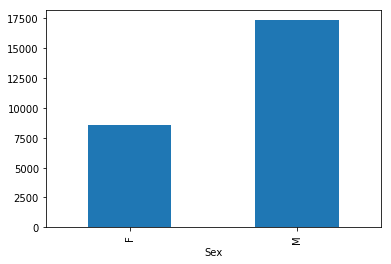

In [17]:
#Checking F/M counts to make sure if we segment the data, there would still be enough to analyze both groups
df.groupby('Sex').size().plot(kind='bar')

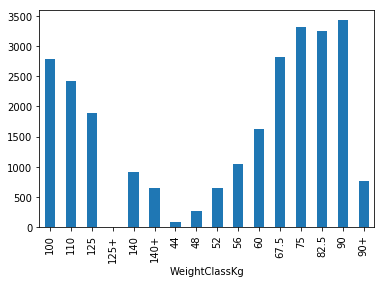

In [18]:
df.groupby('WeightClassKg').size().plot(kind='bar')

In [19]:
df['Equipment'].unique()

array(['Single-ply', 'Raw', 'Multi-ply', 'Wraps'], dtype=object)

In [20]:
#We want to look at RAW strength, Wraps is considered raw in most federations, single/muti-ply lifting 
#means use of specialized equipment to increase weights lifted
df = df.loc[(df['Equipment'] == 'Raw')  | (df['Equipment'] == 'Wraps')]

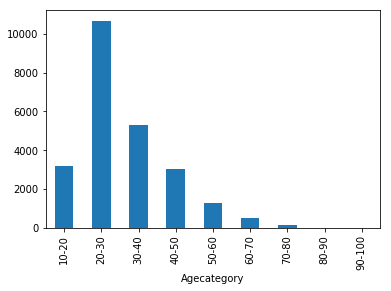

In [21]:
# We will focus on the group that has the most values
df.groupby('Agecategory').size().plot(kind='bar')

In [22]:
df = df.loc[df['Agecategory'] == '20-30']

In [23]:
#Segmenting M/F - illogical to compare Males and Females
m_df = df.loc[df['Sex'] == 'M']
f_df = df.loc[df['Sex'] == 'F']

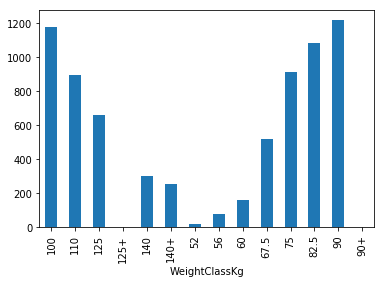

In [24]:
m_df.groupby('WeightClassKg').size().plot(kind='bar')

In [25]:
#Segmenting Data based on weight class, we can't compare the strength of someone of two different weight classes
#Someone who is 110kg's is inherently stronger than someone of a lower weight class
m_70_df = m_df.loc[m_df['WeightClassKg'] == '75']
m_82_df = m_df.loc[m_df['WeightClassKg'] == '82.5']
m_90_df = m_df.loc[m_df['WeightClassKg'] == '90']
m_100_df = m_df.loc[m_df['WeightClassKg'] == '100']
m_110_df = m_df.loc[m_df['WeightClassKg'] == '110']

In [26]:
m_82_df.head()

,MeetID,Federation,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks,Agecategory
Date,,,,,,,,,,,,,,,
2011-05-21,7553,USPA,M,Raw,26.0,Open,81.92,82.5,185.0,152.5,200.0,537.5,1,361.610,20-30
2011-07-01,7554,USPA,M,Raw,25.0,Open,78.47,82.5,195.0,130.0,220.0,545.0,1,376.700,20-30
2011-08-13,7559,USPA,M,Raw,23.0,Junior Men 20-23,80.92,82.5,172.5,122.5,192.5,487.5,1,330.443,20-30
2011-09-10,7564,USPA,M,Raw,20.0,Junior Men 20-23,79.61,82.5,207.5,150.0,245.0,602.5,1,412.600,20-30
2011-10-09,7567,USPA,M,Raw,22.0,Jr Men 20-23,80.74,82.5,182.5,125.0,187.5,495.0,1,335.990,20-30


### Indexing Time to Make Time Series Data

In [27]:
# At this point, we only really care about the numbers, so we will drop categories and take the average the meet
# From each month
m_82_ = m_82_df.drop(m_82_df[['MeetID','Federation', 'Sex', 'Equipment', 'Age', 'Division', 'BodyweightKg', 'Place', 'Wilks']], axis=1)
m_82 = m_82_[['BestSquatKg','BestBenchKg','BestDeadliftKg', 'TotalKg']].resample('MS').mean()

In [28]:
m_82 = m_82.rename(index=str, columns={"BestSquatKg": "AvgSquatKg", "BestBenchKg": "AvgBenchKg", "BestDeadliftKg":"AvgDeadliftKg", "TotalKg":"AvgTotalKg"})

m_82.head()


,AvgSquatKg,AvgBenchKg,AvgDeadliftKg,AvgTotalKg
Date,,,,
2011-05-01 00:00:00,185.0,152.5,200.0,537.5
2011-06-01 00:00:00,NaN,NaN,NaN,NaN
2011-07-01 00:00:00,195.0,130.0,220.0,545.0
2011-08-01 00:00:00,172.5,122.5,192.5,487.5
2011-09-01 00:00:00,207.5,150.0,245.0,602.5


In [29]:
#Forward fill NaN values to impute missing months when competitions did not occur
m_82 = m_82.fillna(method='ffill').reset_index()
m_82.head()

,Date,AvgSquatKg,AvgBenchKg,AvgDeadliftKg,AvgTotalKg
0,2011-05-01 00:00:00,185.0,152.5,200.0,537.5
1,2011-06-01 00:00:00,185.0,152.5,200.0,537.5
2,2011-07-01 00:00:00,195.0,130.0,220.0,545.0
3,2011-08-01 00:00:00,172.5,122.5,192.5,487.5
4,2011-09-01 00:00:00,207.5,150.0,245.0,602.5


In [30]:
m_82['Date'] = pd.to_datetime(m_82['Date'])

In [31]:
m_82 = m_82.set_index('Date')
m_82.index

DatetimeIndex(['2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
      

In [45]:
m_82 = m_82['2012':'2017']
m_82.index

DatetimeIndex(['2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
      

## Exploratory Data Analysis

### Visualizing Trend

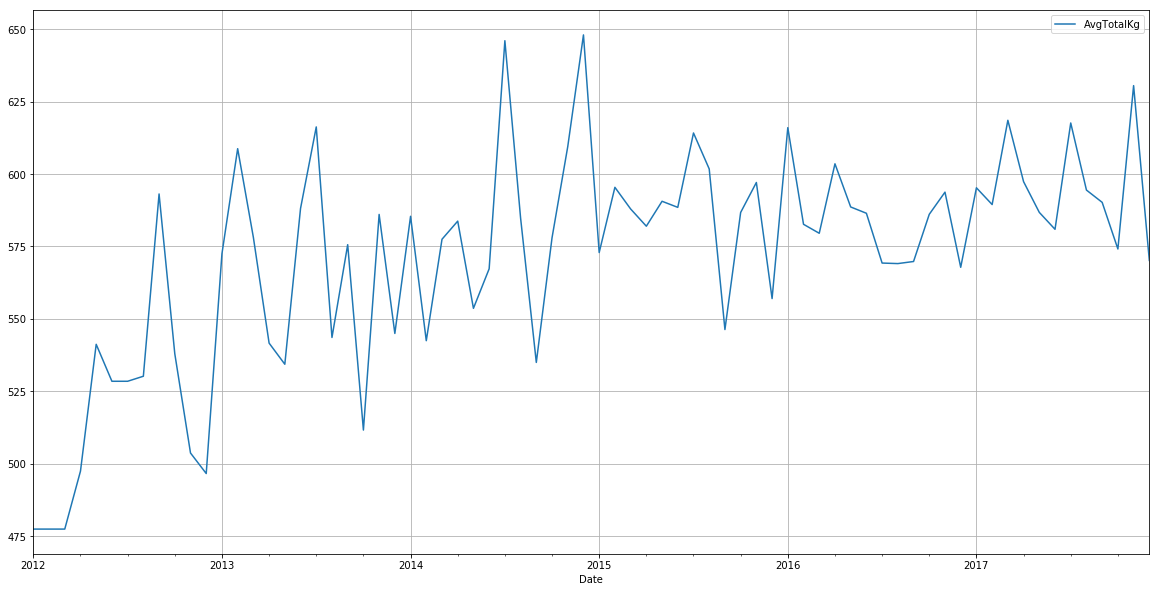

In [46]:
m_82[['AvgTotalKg']].plot(figsize=(20,10), grid = True)

### Identifying Trend in TS

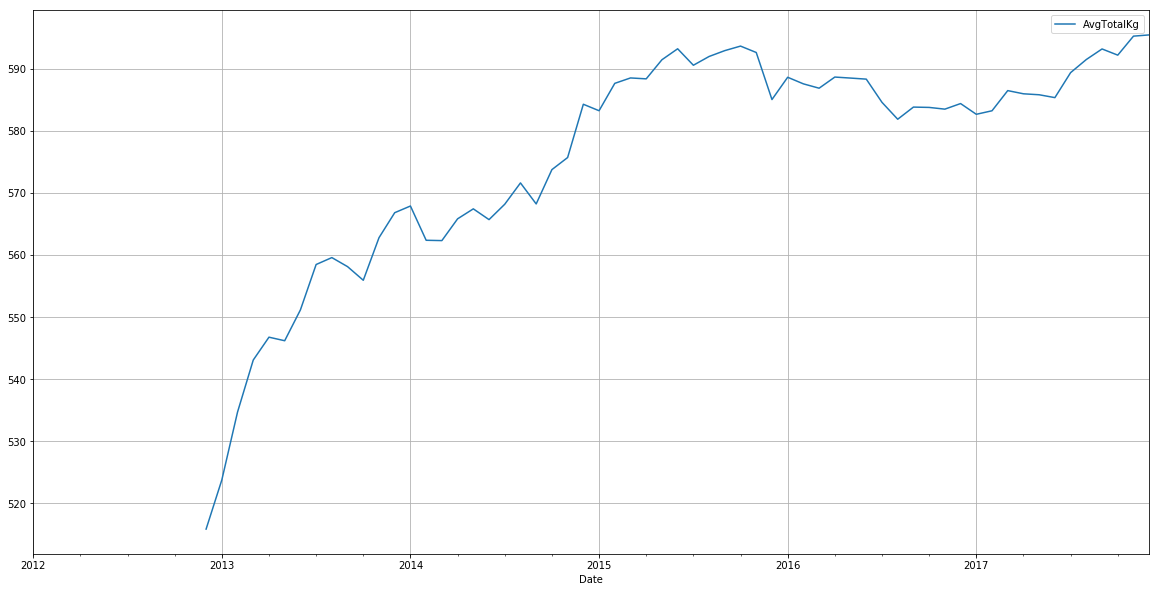

In [47]:
total = m_82[['AvgTotalKg']]
total.rolling(12).mean().plot(figsize=(20,10), grid = True)

### Doing the same for the three seperate lifts

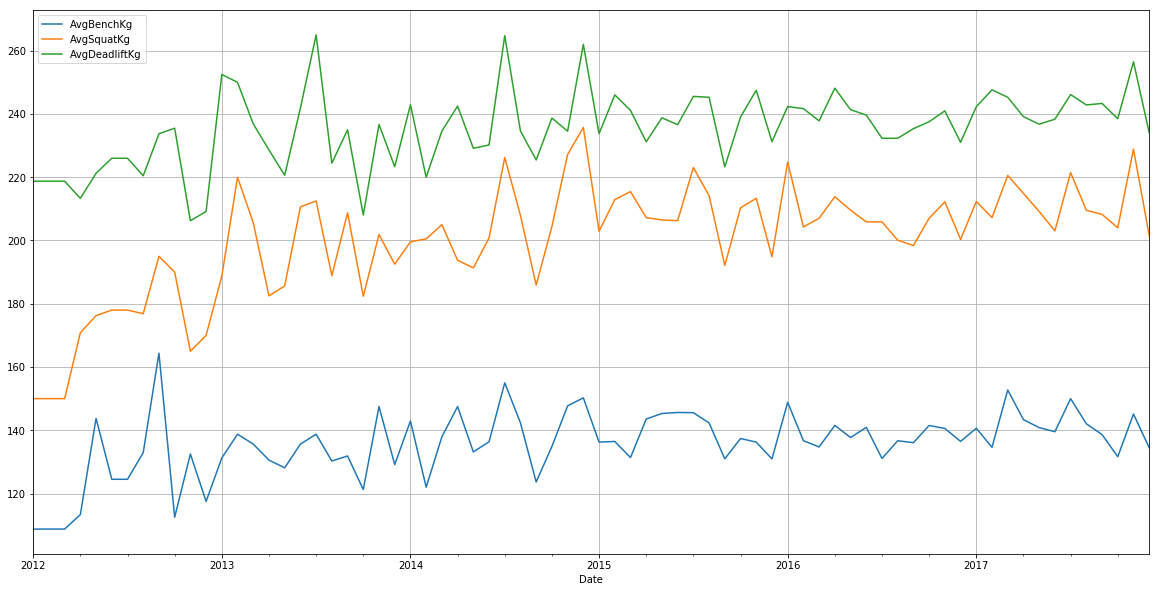

In [48]:
m_82[['AvgBenchKg', 'AvgSquatKg', 'AvgDeadliftKg']].plot(figsize = (20,10), grid = True)

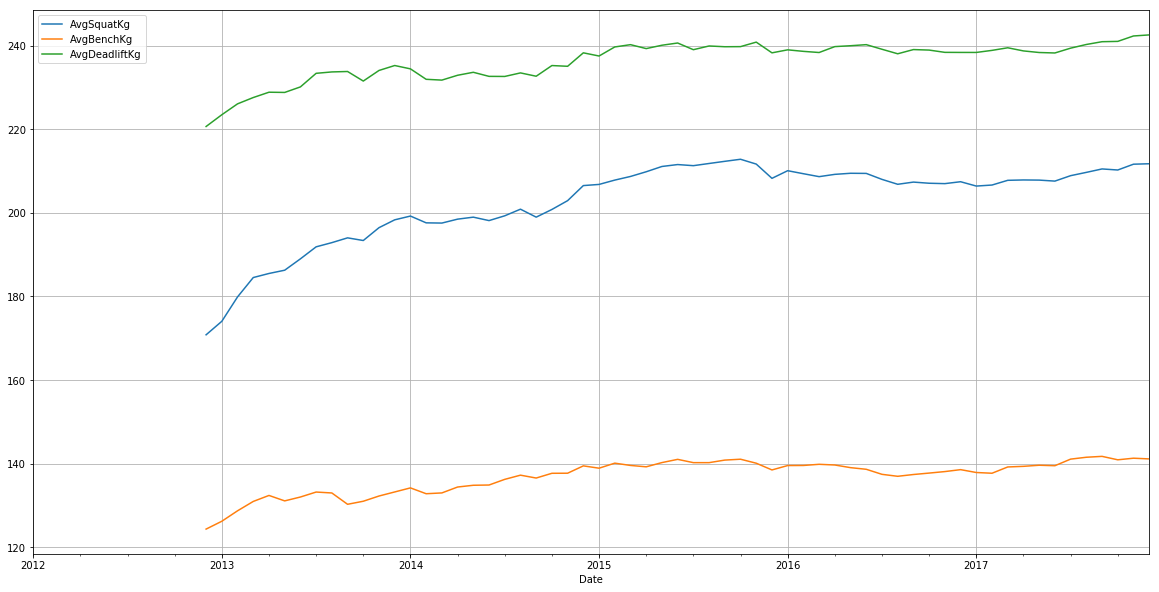

In [49]:
sbd_82 = m_82[['AvgSquatKg', 'AvgBenchKg', 'AvgDeadliftKg']]
sbd_82.rolling(12).mean().plot(figsize=(20,10), grid = True)

### STL Decomposition

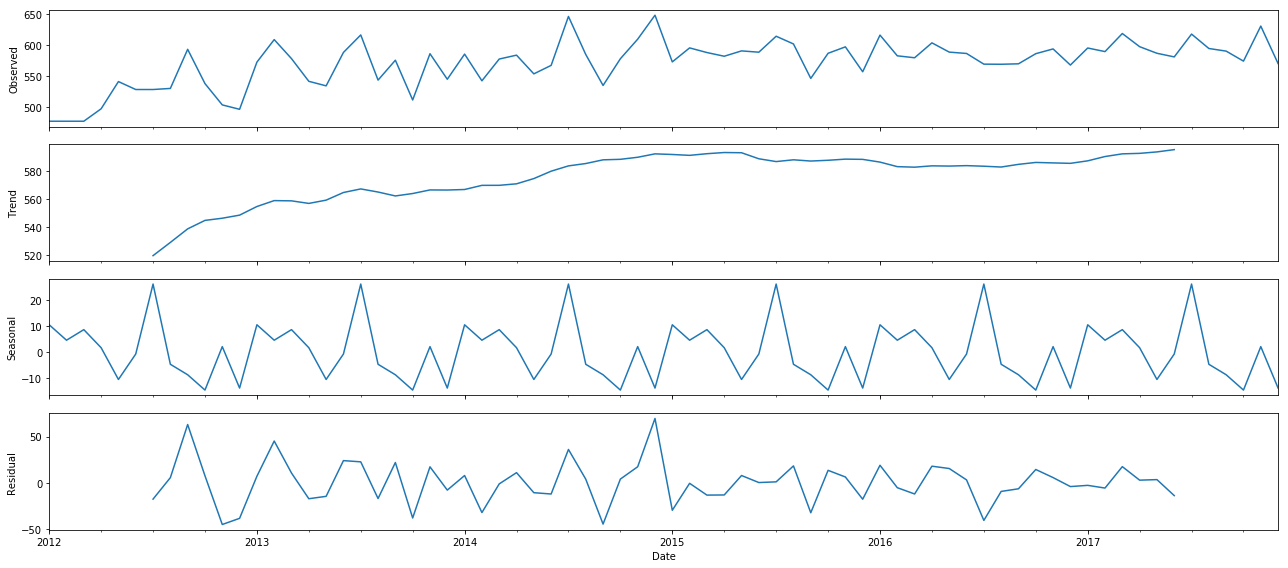

In [61]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(total, model='additive')
fig = decomposition.plot()
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


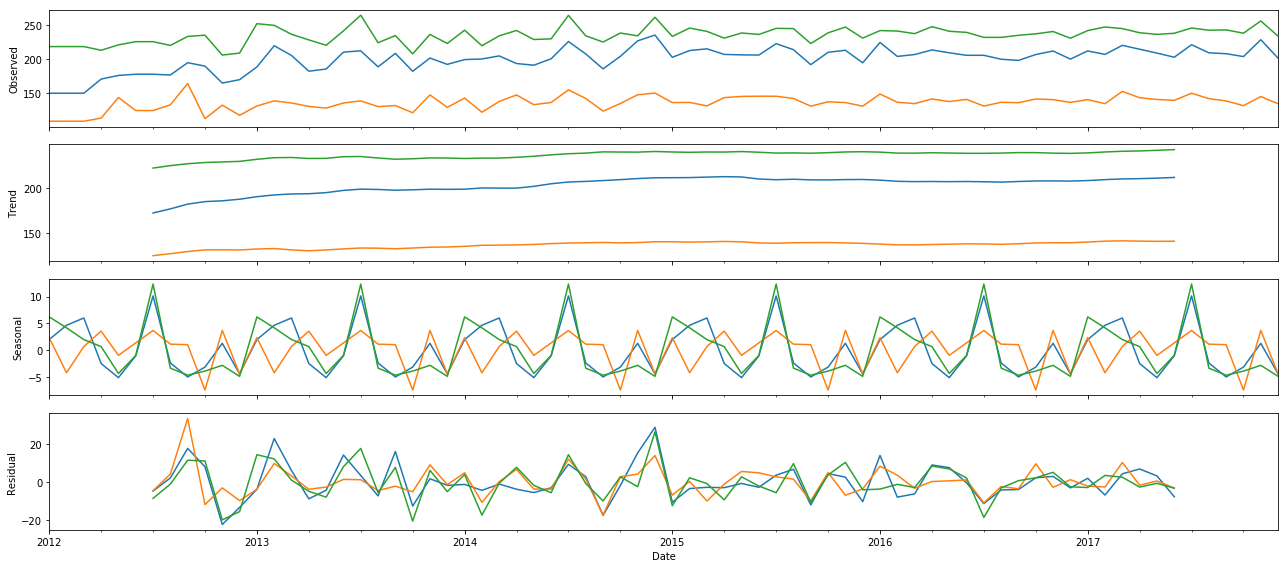

In [62]:
#STL Decomp for three seperate lifts
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(sbd_82, model='additive')
fig = decomposition.plot()
plt.show()

In [63]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [64]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(total, order=param, seasonal_order=param_seasonal, enforce_stationarity=False,enforce_invertibility=False, missing="drop")
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1105.661776742944
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:924.3037187849765
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:611.5140361552901
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:466.18997123006335
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:621.5146256054962
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:596.6446445719985
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:476.0710947385517


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:464.4920380291305
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1006.2393164777476


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python

ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:838.4156050102026
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:591.4187830581889
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:457.331587270614
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:620.8852416949551


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:594.3718932359285
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:478.07109172183937
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:455.56811794119676


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-

ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:705.8455684872383
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:586.1294323280592
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:622.670207146239
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:474.4771794895659
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:595.8914412335835
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:587.655979628397
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:495.8793697067916
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:475.72548289283606
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:669.3896074984189
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:541.415982428494
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:586.5537858200267


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:440.94030907545306
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:558.860904097485
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:542.780023394528


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:466.9423359579352
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:436.6673005858557
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:716.8933717879736


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python

ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:598.3911900156804
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:607.4938065386227
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:468.0940656912276
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:597.8097686831297
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:592.8512449614904
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:468.471801267446
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:466.3049699537012


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:680.0672384347758


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:550.3146057194203
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:584.2240531536145


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:441.7660704713027


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:595.7153667521101


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:572.4838426725906
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:464.38576059268814


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:440.71733093438064
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:697.2926858776071
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:571.6431632833549
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:612.0683384448517
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:465.6567812869737


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:572.6356044753413
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:573.4306051687545
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:471.8607157551083


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:464.9443168139066
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:671.0465562613969
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:542.9878857198104
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:588.5522550215969


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:442.5669189872274
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:550.405926810111


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:544.69001914351
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:455.8156153772071


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:438.0399742197658


In [65]:
#ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:533.6332526522013

In [66]:
mod = sm.tsa.statespace.SARIMAX(total, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8287      0.108     -7.662      0.000      -1.041      -0.617
ma.S.L12      -0.6587      0.203     -3.245      0.001      -1.057      -0.261
sigma2       873.4313    146.301      5.970      0.000     586.687    1160.176


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


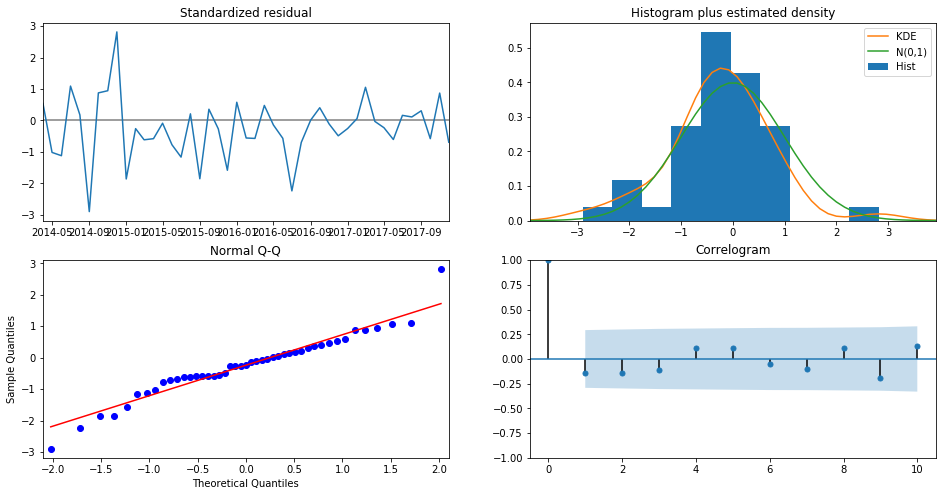

In [67]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()